# Tinanic Survival

* Dataset has been obtained from kaggle.com

## Data Analysis

To begin with, the train and test datasets are loaded using pandas and both are concatenated in only one dataset. Probably this will ease the way of working.

In [1]:
import numpy as np
import pandas as pd

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
data = pd.concat([train, test])

#size of training dataset
train_samples = train.shape[0]

#print some of them
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [2]:
#show the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Data Engineering
### Dropping

There are a few number of features that can be removed. Apparently things like the ticket, the passenger id, the place where the people had embarked or their names should not be relevant.

In [3]:
#Dropping useless features
data = data.drop(['Cabin', 'Embarked', 'Fare', 'Name', 'PassengerId', 'Ticket'], axis=1)
data.head(10)

,Age,Parch,Pclass,Sex,SibSp,Survived
0,22.0,0,3,male,1,0.0
1,38.0,0,1,female,1,1.0
2,26.0,0,3,female,0,1.0
3,35.0,0,1,female,1,1.0
4,35.0,0,3,male,0,0.0
5,NaN,0,3,male,0,0.0
6,54.0,0,1,male,0,0.0
7,2.0,1,3,male,3,0.0
8,27.0,2,3,female,0,1.0
9,14.0,0,2,female,1,1.0


### Family Size

Obviously the family size is quite important because it can affect directly if a person gets survived or not. The dataset has two features related to this meaning, 'SibSp' and 'Parch'. The first one is 'siblings and spouse' and the second one means 'parents and childs'. Both features are defined as numbers so they can be transform as a new one with the size of the family. It's only necessary to sum both and asign the correspondent size. It's going to be taken the following sizes: 'alone', 'medium' (1-4) and 'large' (more than 4).

After that, the original features will be deleted.

In [4]:
#New column to know if the passenger has family on board
def family(size):
    if size == 0:
        return "alone"
    elif size < 5:
        return "medium"
    else:
        return "large"

data['FamilySize'] = (data['SibSp']+data['Parch']).apply(family)
data = data.drop(['SibSp', 'Parch'], axis=1)

data.head()

,Age,Pclass,Sex,Survived,FamilySize
0,22.0,3,male,0.0,medium
1,38.0,1,female,1.0,medium
2,26.0,3,female,1.0,alone
3,35.0,1,female,1.0,medium
4,35.0,3,male,0.0,alone


### Filling 'Age' NaN with Mean

Train and test datasets have many rows with empty values. The strategy that will be taken in order to get all the features filled will be to fill in the blank with the mean.

In [5]:
cond = (data['Sex']=='female') & (data['Pclass']==3)
data.groupby(['Survived','Sex','Pclass'])['Age'].mean()
data[cond].groupby(['Sex','Pclass'])['Age'].mean()

Sex     Pclass
female  3         22.185329
Name: Age, dtype: float64

In the case of __age__ is not that easy. There could be a little correlation between the class where the passenger is traveling, the gender of it and if the passenger has survived or not. So it's a big deal to take into account these three features to calculate the most likely age.

In [6]:
def getAge(row):
    surv = row.Survived
    sex = row.Sex
    pclass = row.Pclass
    
    if surv==0 or surv==1:
        condition = (data['Survived']==surv) & (data['Sex']==sex) & (data['Pclass']==pclass)
        df_mean = data[condition].groupby(['Survived','Sex','Pclass'])['Age'].mean()
    else:
        condition = (data['Sex']==sex) & (data['Pclass']==pclass)
        df_mean = data[condition].groupby(['Sex','Pclass'])['Age'].mean()
    
    #print("surv: {}, sex: {}, class: {} -> age (mean): {}".format(surv, sex, pclass, df_mean.mean()))
    return df_mean.mean()
    
data['Age'] = data['Age'].fillna(data.apply(getAge, axis=1))

In [7]:
len(data['Age']) - data['Age'].count()

0

### Age Range: Grouping

Similar to the 'familty size' (engineered feature), the age can be represented and categorized. The possible classes are going to be: child, young, adult and old.

In [8]:
#define age by ranges
def getAgeRange(age):
    if age < 5:
        return "child"
    elif age < 20:
        return "young"
    elif age < 50:
        return "adult"
    else:
        return "old"

data['Age'] = data['Age'].apply(getAgeRange)

In [9]:
# Age distribution
data.groupby(['Age'])['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
Age,,,,,,,,
adult,626.0,0.333866,0.471970,0.0,0.0,0.0,1.0,1.0
child,40.0,0.675000,0.474342,0.0,0.0,1.0,1.0,1.0
old,74.0,0.364865,0.484678,0.0,0.0,0.0,1.0,1.0
young,151.0,0.523179,0.501125,0.0,0.0,1.0,1.0,1.0


### Getting Feature Dummies

The features that are categorical have to be converted to dummies. On this way we'll have new "numerical" features.

In [10]:
#Transform categorical to dummies
data = pd.get_dummies(data)

### Checking NaN

Only the test dataset should have NaN values. In fact only in the 'Survived' column.

In [11]:
#finding NaN
data.columns[data.isnull().any()].tolist()

['Survived']

### Normalizing

Probably the range of numerical features are not the same and this could produce problems in our results. A proper way to get good calculations is normalizing all the features.

In this case we're going to use the minmax scaler because it transform the range of the features to values between 0 and 1.

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,1309.0,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Survived,891.0,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Age_adult,1309.0,0.723453,0.447461,0.0,0.0,1.0,1.0,1.0
Age_child,1309.0,0.038961,0.193576,0.0,0.0,0.0,0.0,1.0
Age_old,1309.0,0.084034,0.277544,0.0,0.0,0.0,0.0,1.0
Age_young,1309.0,0.153552,0.360657,0.0,0.0,0.0,0.0,1.0
Sex_female,1309.0,0.355997,0.478997,0.0,0.0,0.0,1.0,1.0
Sex_male,1309.0,0.644003,0.478997,0.0,0.0,1.0,1.0,1.0
FamilySize_alone,1309.0,0.603514,0.489354,0.0,0.0,1.0,1.0,1.0
FamilySize_large,1309.0,0.045837,0.209210,0.0,0.0,0.0,0.0,1.0


Avoiding the dummy features, we see 'pclass' is not moving between a range of (0,1).

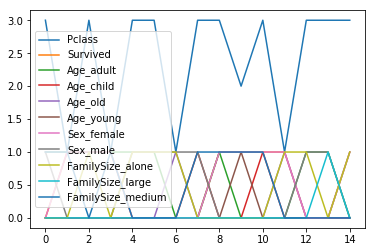

In [13]:
import matplotlib.pyplot as plt

data.head(15).plot()
plt.show()

After the scaler we'll have all the features in the same range. This speeds up the calculations because all are small numbers which are easy to use (better performance).

The picture below shows the features ranges.

Train shape: (1309, 11)


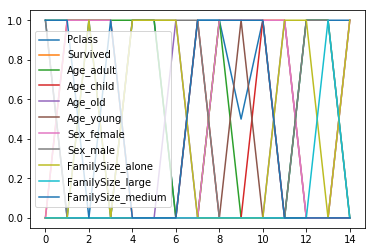

,count,mean,std,min,25%,50%,75%,max
Pclass,1309.0,0.647441,0.418918,0.0,0.5,1.0,1.0,1.0
Survived,891.0,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Age_adult,1309.0,0.723453,0.447461,0.0,0.0,1.0,1.0,1.0
Age_child,1309.0,0.038961,0.193576,0.0,0.0,0.0,0.0,1.0
Age_old,1309.0,0.084034,0.277544,0.0,0.0,0.0,0.0,1.0
Age_young,1309.0,0.153552,0.360657,0.0,0.0,0.0,0.0,1.0
Sex_female,1309.0,0.355997,0.478997,0.0,0.0,0.0,1.0,1.0
Sex_male,1309.0,0.644003,0.478997,0.0,0.0,1.0,1.0,1.0
FamilySize_alone,1309.0,0.603514,0.489354,0.0,0.0,1.0,1.0,1.0
FamilySize_large,1309.0,0.045837,0.209210,0.0,0.0,0.0,0.0,1.0


In [14]:
#Squeeze the data to [0,1]
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
data[['Pclass']] = scaler.fit_transform(data[['Pclass']])
print("Train shape: {}".format(data.shape))

data.head(15).plot()
plt.show()
data.describe().T

### Splitting the data to train and test

As a good practive, we're going to split the data into two different datasets, training and testing. Taking the number of training samples (saved in the beginning) we split it.

Besides, we'll use the k-fold method to get different batches of the data (it's configured with 3 splits).

#### StratifiedKFold training set

In [15]:
from sklearn.model_selection import StratifiedKFold

y = np.array(data['Survived'])
X = np.array(data.drop('Survived', axis=1))

#split by idx
idx = train_samples
X_train, X_test = X[:idx], X[idx:]
y_train, y_test = y[:idx], y[idx:]

print("Shape train: {}".format(X_train.shape))
print("Shape test: {}".format(X_test.shape))
#print(y_train[0:1])
#print(X_train[0:1].tolist())

kf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
print(kf)

Shape train: (891, 10)
Shape test: (418, 10)
StratifiedKFold(n_splits=3, random_state=42, shuffle=True)


#### Voting Ensemble

Although it had been configured a few classifiers that were going to be used with an ensemble method and all the classifiers had the same weight, it was seen the accuracy was bigger when the random forest classifier was used alone.

For this reason, part of the previous code is commented and 'clf2' is used.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


clf1 = LogisticRegression(random_state=42, warm_start=True)
clf2 = RandomForestClassifier(random_state=42, warm_start=True)
clf3 = GaussianNB()

#eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                        #voting='soft')

estimators = 10
epoch = 1
for train_idx, val_idx in kf.split(X_train, y_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]
    
    clf2.set_params(n_estimators=estimators*epoch)
    epoch += 1
    # predict class probabilities for all classifiers
    #probas = [c.fit(X_train, y_train.reshape(-1)).predict_proba(X_test) for c in (clf1, clf2, clf3, eclf)]
    clf2.fit(X_train, y_train.reshape(-1))
    
    scores = cross_val_score(clf2, X_v, y_v.reshape(-1))
    print("Scores({}): {}".format(epoch-1, scores))

#sample = 13
#class_surv = [pr[sample, 0] for pr in probas]
#class_not_surv = [pr[sample, 1] for pr in probas]
#print("Probabilities survived (1): {}".format(class_surv))
#print("Probabilities not survived (0): {}".format(class_not_surv))

Scores(1): [ 0.77777778  0.85858586  0.87878788]
Scores(2): [ 0.75757576  0.75757576  0.74747475]
Scores(3): [ 0.81818182  0.75757576  0.86868687]


### Metrics (scikit-learn)

Finally, we only need to print the classification report and the confusion matrix and see the outcome.

[[159   6]
 [ 35  68]]


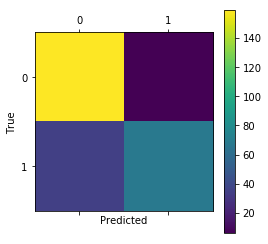

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

Xs_train, Xs_val, ys_train, ys_val = train_test_split(X_train, y_train, test_size=0.3)
ys_val = np.reshape(ys_val, [-1,1])

predictions = clf2.predict(Xs_val)
cm = confusion_matrix(ys_val, predictions)
print(cm)
plt.matshow(cm)
plt.colorbar()
ax = plt.gca()
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

plt.show()

In [18]:
print(classification_report(ys_val, predictions))

             precision    recall  f1-score   support

        0.0       0.82      0.96      0.89       165
        1.0       0.92      0.66      0.77       103

avg / total       0.86      0.85      0.84       268



## Get Predictions

In [19]:
import os

predictions = clf2.predict(X_test)

passengerId = 892
file = "PassengerId,Survived" + os.linesep

for i in range(len(X_test)):
    file += "{},{}".format(passengerId, (int)(predictions[i]))  + os.linesep
    passengerId += 1

In [20]:
# Save to file
with open('attempt.txt', 'w') as f:
    f.write(file)